In [7]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

# Go up 3 levels to the repo's root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add the repo root to sys.path
sys.path.append(repo_root)

from data_processing.helpers import normalize, sample
from data_processing.load_data_functions import load_elmer_results
from models.initialization import init_single_net, neural_net, init_pinns, create_solution
from equations.momentum_conservation import gov_eqn as gov_eqn_momentum
from equations.simple_mass_conservation import gov_eqn as gov_eqn_mass

from models.optimization import adam_optimizer, lbfgs_optimizer

Next, we load in our data. This is a custom function, stored in the data_processing folder. The results are standardized though!

In [17]:
csv = '../../elmer_results/results/pvm.csv'
df_filtered, df_surface, df_divide, df_bed, df_flanks = load_elmer_results(csv,0,4000)

Everything is loaded! Next, we initialize the PINN for our problem. 

Testing code

In [18]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [19]:
# normalize
df_norm,df_bcs,info = normalize(df_filtered, df_surface, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

The loss function is where i will whittle down data into relevant bits. This way I can use multiple equations. Equations also have to fit the generalized data structure. Initializing the solution function has to be a general thing as well then.

In [20]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


Now we make our samples for Adam and L-BFGS. For this simple mass conservation, we need the boundaries at the bed, divide, and surface.

In [21]:
# for adam
n_samples = jnp.array([400,400]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

Assuming that we have defined our equations properly, now we need to define our loss function (i.e. the function to create the loss function). This is the custom function that lies within the notebook

In [22]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_momentum_mass(predf,gov_eqn_momentum,gove_eqn_mass,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        x_smp = data['smp'][0]
        w_smp = data['smp'][1][:,1:2] # ground truth w
        x_div = data['div'][0]
        u_div = data['div'][1][:,0:1] # horizontal velocity at divide (should be 0)
        x_bed = data['bed'][0]
        w_bed = data['bed'][1][:,1:2] # ground truth w at bed (should be 0)
        rho_bed = data['bed'][1][:,2:3] # ground truth rho at bed (should be rho_i)
        x_surf = data['surf'][0]
        u_surf = data['surf'][1][:,0:1] # ground truth surface horizontal velocity 
        p_surf = data['surf'][1][:,3:4] # ground truth surface ice pressure
        
        # assuming known viscosities at flanks
        x_flanks = data['flanks'][0]
        mu_flanks = data['flanks'][1][:,4:5]

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        w_pred = net(x_smp)[:, 1:2]

        # boundary constraints
        u_div_pred = net(x_div)[:,0:1]
        bed_pred = net(x_bed)
        w_bed_pred = bed_pred[:,1:2]
        rho_bed_pred = bed_pred[:,2:3]
        u_surf_pred = net(x_surf)[:,0:1]
        p_surf_pred = net(x_surf)[:,3:4]
        mu_flanks_pred = net(x_flanks)[:,4:5]
        
        # calculate the residue of equation
        f_pred_mass,terms_mass = gov_eqn_mass(net, x_col, scales)
        f_pred_momentum,terms_momentum = gov_eqn_momentum(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(w_pred - w_smp)

        # calculate the mean squared root error of equation
        eqn_err_mass = ms_error(f_pred_mass)
        eqn_err_momentum = ms_error(f_pred_momentum)

        # calculate errors of boundary conditions
        p_surf_err = ms_error(p_surf-p_surf_pred)
        flanks_err = ms_error(mu_flanks-mu_flanks_pred)
        div_err = ms_error(u_div_pred-u_div)
        rho_bed_err = ms_error(rho_bed-rho_bed_pred)
        w_bed_err = ms_error(w_bed-w_bed_pred)
        u_surf_err = ms_error(u_surf-u_surf_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err_mass)+jnp.sum(eqn_err_momentum)
        loss_bd = jnp.sum(flanks_err) + jnp.sum(p_surf_err) + jnp.sum(div_err) + jnp.sum(rho_bed_err) + jnp.sum(w_bed_err) + jnp.sum(u_surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err_mass,eqn_err_momentum, flanks_err,p_surf_err,u_surf_err,
                               div_err, rho_bed_err, w_bed_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [34]:
# create the loss function
NN_loss = create_loss_momentum_mass(pred_u, gov_eqn_momentum,gov_eqn_mass, info, [1,1,10])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [35]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 9.9896e-01 | Loss_d: 1.2050e-02 | Loss_e: 1.9894e-01 | Loss_b: 3.4046e+05
Step: 200 | Loss: 9.9791e-01 | Loss_d: 1.0823e-02 | Loss_e: 2.2999e-01 | Loss_b: 3.4010e+05
Step: 300 | Loss: 9.9686e-01 | Loss_d: 6.6181e-03 | Loss_e: 2.4754e-01 | Loss_b: 3.3974e+05
Step: 400 | Loss: 9.9581e-01 | Loss_d: 7.8858e-03 | Loss_e: 2.4111e-01 | Loss_b: 3.3939e+05
Step: 500 | Loss: 9.9476e-01 | Loss_d: 6.0120e-03 | Loss_e: 2.7474e-01 | Loss_b: 3.3903e+05
Step: 600 | Loss: 9.9372e-01 | Loss_d: 9.1322e-03 | Loss_e: 3.0188e-01 | Loss_b: 3.3867e+05
Step: 700 | Loss: 9.9267e-01 | Loss_d: 8.0045e-03 | Loss_e: 2.9723e-01 | Loss_b: 3.3831e+05
Step: 800 | Loss: 9.9162e-01 | Loss_d: 8.3286e-03 | Loss_e: 2.8604e-01 | Loss_b: 3.3796e+05
Step: 900 | Loss: 9.9058e-01 | Loss_d: 7.9390e-03 | Loss_e: 3.0637e-01 | Loss_b: 3.3760e+05
Step: 1000 | Loss: 9.8953e-01 | Loss_d: 6.9112e-03 | Loss_e: 3.8098e-01 | Loss_b: 3.3725e+05
Step: 1100 | Loss: 9.8849e-01 | Loss_d: 8.5509e-03 | Loss_e: 2.9829e-01 | Loss_

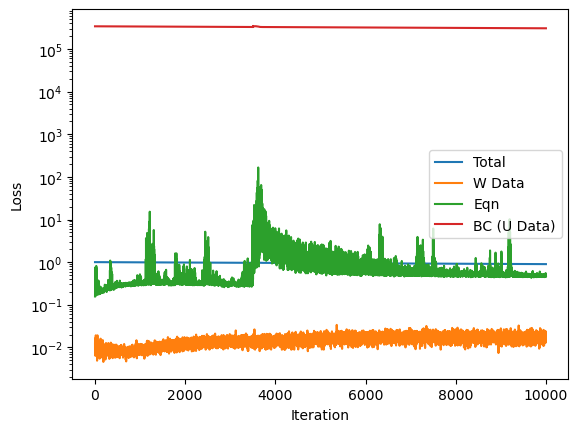

In [36]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [37]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 8.9822e-01 | Loss_d: 1.7761e-02 Loss_e: 4.7534e-01 | Loss_b: 3.0613e+05


2025-03-25 08:40:06.972905: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m2.445675s

********************************
[Compiling module jit_while] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Step: NaN | Loss: 8.9822e-01 | Loss_d: 1.7761e-02 Loss_e: 4.7555e-01 | Loss_b: 3.0612e+05
Step: NaN | Loss: 8.9820e-01 | Loss_d: 1.7761e-02 Loss_e: 4.7661e-01 | Loss_b: 3.0612e+05
Step: NaN | Loss: 8.9814e-01 | Loss_d: 1.7759e-02 Loss_e: 4.8676e-01 | Loss_b: 3.0610e+05
Step: NaN | Loss: 8.9783e-01 | Loss_d: 1.7752e-02 Loss_e: 4.9400e-01 | Loss_b: 3.0599e+05
Step: NaN | Loss: 8.9881e-01 | Loss_d: 1.7717e-02 Loss_e: 6.5628e-01 | Loss_b: 3.0633e+05
Step: NaN | Loss: 8.9762e-01 | Loss_d: 1.7747e-02 Loss_e: 4.7946e-01 | Loss_b: 3.0592e+05
Step: NaN | Loss: 8.9717e-01 | Loss_d: 1.7732e-02 Loss_e: 5.1803e-01 | Loss_b: 3.0577e+05
Step: NaN | Loss: 8.9717e-01 | Loss_d: 1.7732e-02 Loss_e: 5.1916e-01 | Loss_b: 3.0577e+05
Step: NaN | Loss: 8.9580e-01 | Loss_d: 1.7699e-02 Loss_e: 8.0012e-01 | Loss_b: 3.0530e+05
Step: NaN | Loss: 8.9082e-01 | Loss_d: 1.7573e-02 Loss_e: 5.1141e-01 | Loss_b: 3.0360e+05
Step: NaN | Loss: 8.7711e-01 | Loss_d: 1.6993e-02 Loss_e: 1.1715e+00 | Loss_b: 2.9893e+05
Step: NaN 

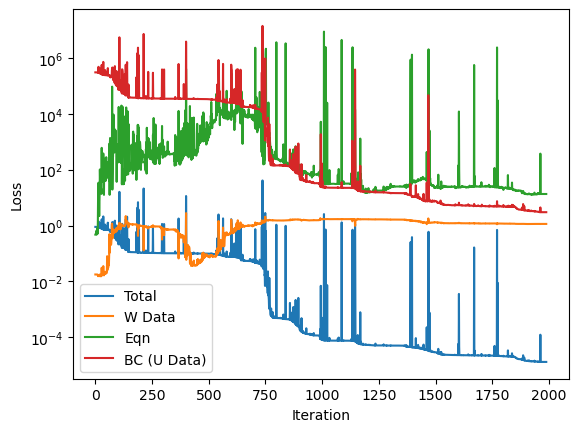

In [38]:
plot_loss(loss2)

In [46]:
loss2[1].shape

(4,)

In [39]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn_momentum = lambda x: gov_eqn_momentum(f_u, x, info)
f_eqn_mass = lambda x: gov_eqn_mass(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list_mass = tree_map(lambda x: f_eqn_mass(x_psp[x]), idxsp)
eqn_list_mass = tree_map(lambda x: eqnterm_list_mass[x][0], idxsp)
term_list_mass = tree_map(lambda x: eqnterm_list_mass[x][1], idxsp)
eqnterm_list_momentum = tree_map(lambda x: f_eqn_momentum(x_psp[x]), idxsp)
eqn_list_momentum = tree_map(lambda x: eqnterm_list_momentum[x][0], idxsp)
term_list_momentum = tree_map(lambda x: eqnterm_list_momentum[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn_mass = jnp.vstack(eqn_list_mass)
term_mass = jnp.vstack(term_list_mass)
eqn_momentum = jnp.vstack(eqn_list_momentum)
term_momentum = jnp.vstack(term_list_momentum)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_filtered[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_filtered['x'].values
results['z'] = df_filtered['z'].values

# temporary fix for pressures being in MPa
results['p_p'] = results['p_p']/1e6

In [40]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*info['w_range']/info['z_range']
results['e0']=eqn_mass[:, 0:1] * term0
results['e01']=term_mass[:, 0:1] * term0
results['e02']=term_mass[:, 1:2] * term0

term1 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn_momentum[:, 0:1] * term1
results['e11']=term_momentum[:, 0:1] * term1
results['e12']=term_momentum[:, 1:2] * term1
results['e13']=term_momentum[:, 2:3] * term1

term2 = info['rho_range']*9.81
results['e2']=eqn_momentum[:, 1:2] * term2
results['e21']=term_momentum[:, 3:4] * term2
results['e22']=term_momentum[:, 4:5] * term2
results['e23']=term_momentum[:, 5:6] * term2

Text(0, 0.5, 'Inversion results')

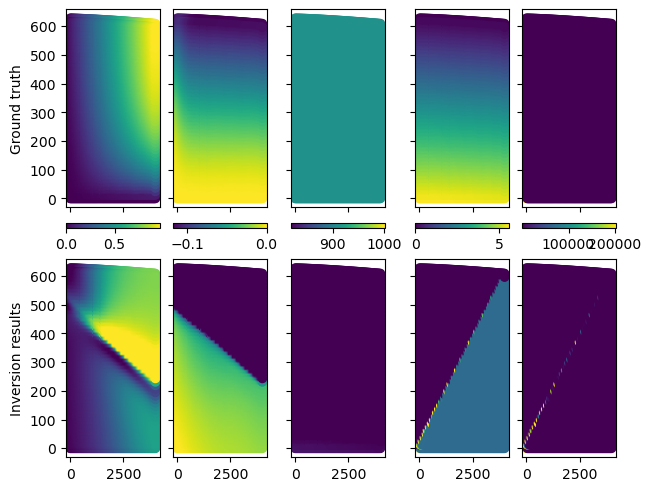

In [41]:
fig, axs = plt.subplots(nrows=2,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')

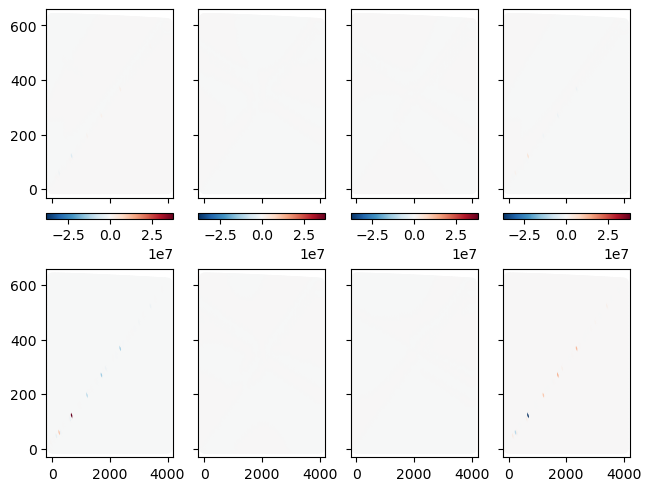

In [42]:
# check equation physics
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x'],results['z'],c=results['e1'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
fig.colorbar(c, ax=axs[0,0], location='bottom')
axs[1,0].scatter(results['x'],results['z'],c=results['e2'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')

for i in range(3):
    c = axs[0,i+1].scatter(results['x'],results['z'],c=results[f'e1{i+1}'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    axs[1,i+1].scatter(results['x'],results['z'],c=results[f'e2{i+1}'],vmin=-vmax,vmax=vmax,cmap='RdBu_r')

In [44]:
# make sure all the terms are in the right units!!!